<a href="https://colab.research.google.com/github/vujjiniashrith/IOT_security/blob/main/Anomaly_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.impute import KNNImputer
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense,ActivityRegularization
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_excel('new_dataset.xlsx')
columns = df.columns
# print(columns)
# columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM']
# df.drop(columns=columns_to_delete, inplace=True)
print(df.columns)

Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3', 'INOP_PLETH',
       'INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM'],
      dtype='object')


In [ ]:
df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3,INOP_PLETH,INOP_SpO2,INOP_RESP,INOP_NOISE,ALARM
0,94,71,71,19,69,113,50,0,0,0,0,0
1,94,71,71,19,69,113,50,0,0,0,0,0
2,94,71,71,17,70,113,51,0,0,0,0,0
3,94,71,71,17,69,113,51,0,0,0,0,0
4,94,71,71,17,69,113,50,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83197,97,79,79,28,121,172,83,0,0,0,0,0
83198,97,79,79,28,125,172,89,0,0,0,0,0
83199,97,79,79,28,123,169,88,0,0,0,0,0
83200,97,79,79,27,120,166,86,0,0,0,0,0


In [ ]:
df=df[['SpO2','HR','PULSE','RESP','ABP1','ABP2','ABP3']]

In [ ]:
df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,94,71,71,19,69,113,50
1,94,71,71,19,69,113,50
2,94,71,71,17,70,113,51
3,94,71,71,17,69,113,51
4,94,71,71,17,69,113,50
...,...,...,...,...,...,...,...
83197,97,79,79,28,121,172,83
83198,97,79,79,28,125,172,89
83199,97,79,79,28,123,169,88
83200,97,79,79,27,120,166,86


In [ ]:
df = df.loc[(df != 0).all(axis=1)]

In [ ]:
df.reset_index(drop = True, inplace = True)

In [ ]:
df.shape

(75380, 7)

<Axes: >

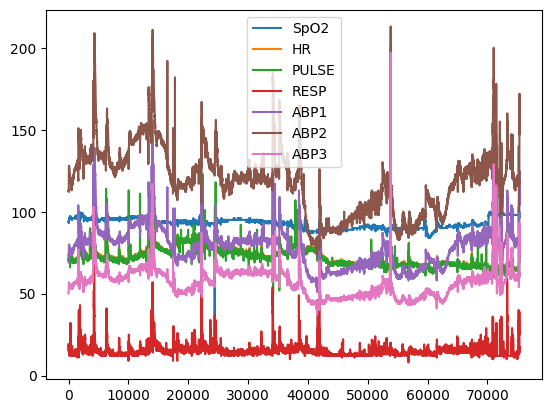

In [ ]:
df.plot( kind='line')

In [ ]:
df.shape

(75380, 7)

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(df)

In [ ]:
len(data)*0.9

67842.0

In [ ]:
train = data[:60304]
test = data[60304:]

In [ ]:
lookback = 256
sequences = []


In [ ]:
for i in range(len(train)-lookback+1):
    sequence = data[i:i+lookback]
    sequences.append(sequence)


In [ ]:
sequences = np.array(sequences)

input_shape = (lookback,7)
latent_dim = 4

In [ ]:
# Define a custom loss function
def custom_loss(y_true, y_pred):
    mse_loss = keras.losses.mean_squared_error(y_true, y_pred)

    # Define a penalty for sudden jumps (adjust weight as needed)
    jump_penalty = 0.5  # Adjust the penalty weight
    jump_loss = keras.backend.mean(keras.backend.square(y_true - y_pred) * jump_penalty)

    # Combine MSE loss and jump penalty
    total_loss = mse_loss + jump_loss

    return total_loss

In [ ]:
input_layer = Input(shape = input_shape)


encoder = LSTM(latent_dim,kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(input_layer)

decoder = RepeatVector(lookback)(encoder)

decoder = LSTM(7, return_sequences=True)(decoder)

autoencoder = keras.Model(input_layer, decoder)
autoencoder.compile(optimizer ='adam',loss = custom_loss)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 4)                 192       
                                                                 
 repeat_vector (RepeatVecto  (None, 256, 4)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 256, 7)            336       
                                                                 
Total params: 528 (2.06 KB)
Trainable params: 528 (2.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_sequences = []
for i in range(len(test)-lookback+1):
    test_sequence = data[i:i+lookback]
    test_sequences.append(test_sequence)
test_sequences = np.array(test_sequences)

encoded_data_test = autoencoder.predict(test_sequences)


464/464 [==============================] - 12s 23ms/step


In [ ]:
autoencoder.fit(sequences, sequences, epochs=20, batch_size=256, validation_data = (test_sequences,test_sequences))

Epoch 1/20
235/235 [==============================] - 33s 141ms/step - loss: 1.1381 - val_loss: 1.1470
Epoch 2/20
235/235 [==============================] - 32s 137ms/step - loss: 0.7595 - val_loss: 0.9841
Epoch 3/20
235/235 [==============================] - 32s 135ms/step - loss: 0.6379 - val_loss: 0.9276
Epoch 4/20
235/235 [==============================] - 31s 132ms/step - loss: 0.6062 - val_loss: 0.9092
Epoch 5/20
235/235 [==============================] - 31s 132ms/step - loss: 0.6311 - val_loss: 0.8782
Epoch 6/20
  5/235 [..............................] - ETA: 28s - loss: 0.6215

KeyboardInterrupt: 

In [ ]:
test_sequences.shape

(14821, 256, 7)

In [ ]:
last_value_test = encoded_data_test[:,-1,:]
reshaped_data_test = last_value_test.reshape(-1, last_value_test.shape[-1])

In [ ]:
original_data_test = scaler.inverse_transform(reshaped_data_test)

In [ ]:
original_df_test = pd.DataFrame(original_data_test, columns=df.columns)

In [ ]:
input_test = scaler.inverse_transform(test)
input_df_test = pd.DataFrame(input_test,columns=df.columns)

In [ ]:
input_df_test.shape

(15076, 7)

In [ ]:
original_df_test.shape

(14821, 7)

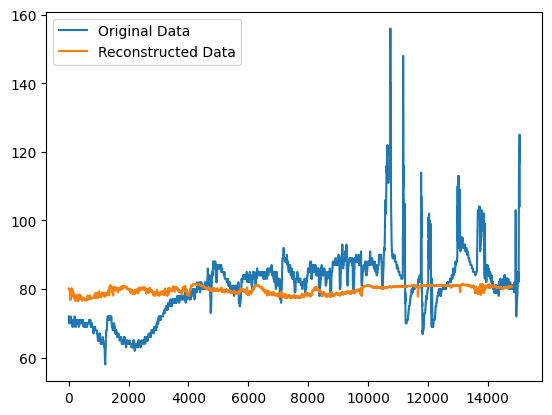

In [ ]:
plt.plot(input_df_test.ABP1, label='Original Data')
plt.plot(original_df_test.ABP1, label='Reconstructed Data')
plt.legend()
plt.show()

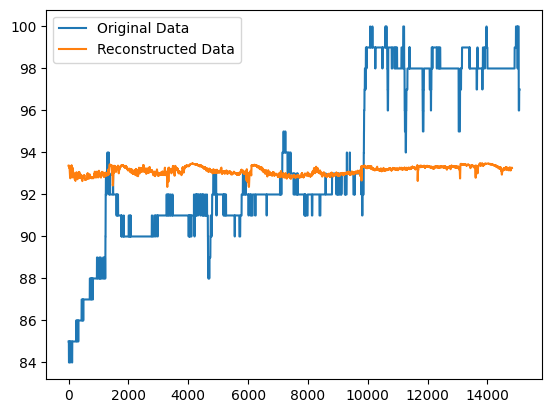

In [ ]:
plt.plot(input_df_test.SpO2, label='Original Data')
plt.plot(original_df_test.SpO2, label='Reconstructed Data')
plt.legend()
plt.show()

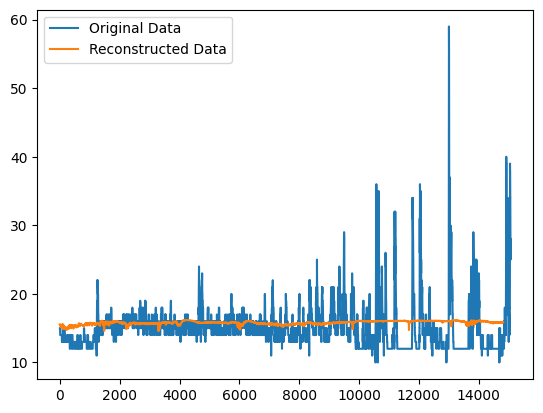

In [ ]:
plt.plot(input_df_test.RESP, label='Original Data')
plt.plot(original_df_test.RESP, label='Reconstructed Data')
plt.legend()
plt.show()

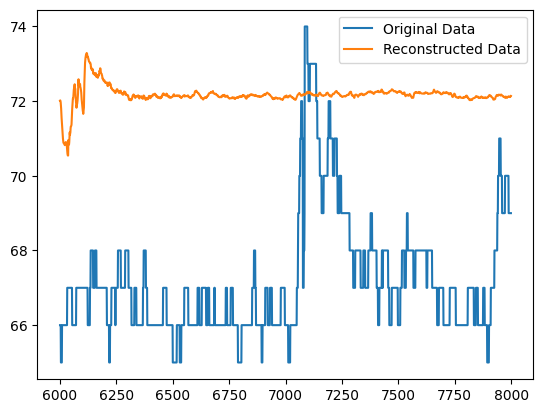

In [ ]:
plt.plot(input_df_test.PULSE[6000:8000], label='Original Data')
plt.plot(original_df_test.PULSE[6000:8000], label='Reconstructed Data')
plt.legend()
plt.show()

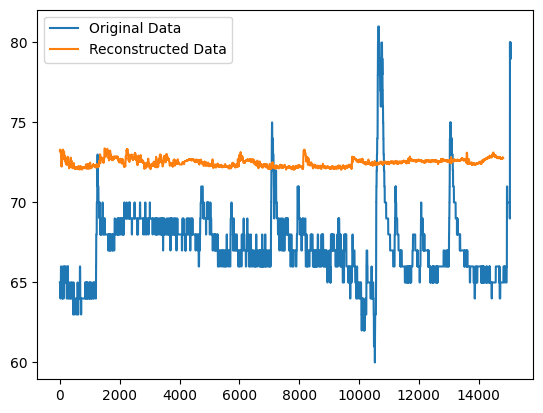

In [ ]:
plt.plot(input_df_test.HR, label='Original Data')
plt.plot(original_df_test.HR, label='Reconstructed Data')
plt.legend()
plt.show()

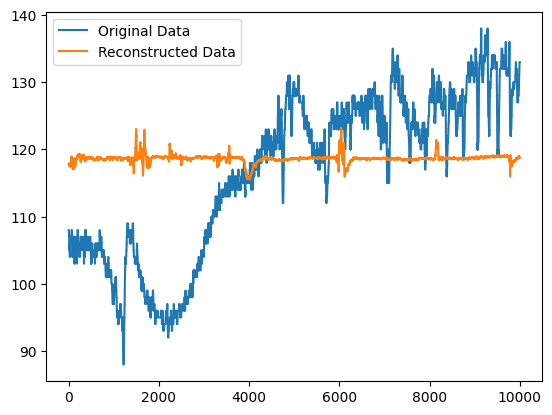

In [ ]:
plt.plot(input_df_test.ABP2[:10000], label='Original Data')
plt.plot(original_df_test.ABP2[:10000], label='Reconstructed Data')
plt.legend()
plt.show()

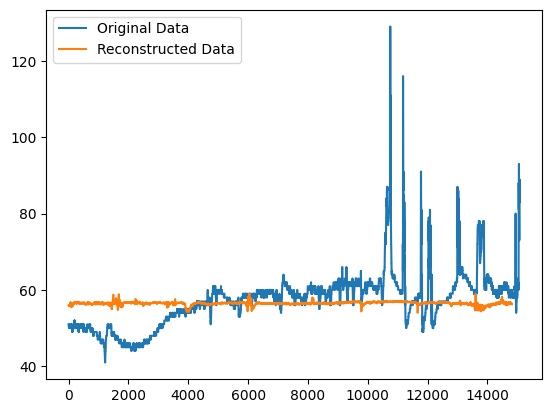

In [ ]:
plt.plot(input_df_test.ABP3, label='Original Data')
plt.plot(original_df_test.ABP3, label='Reconstructed Data')
plt.legend()
plt.show()

In [ ]:
encoded_data_train = autoencoder.predict(sequences)

1877/1877 [==============================] - 46s 24ms/step


In [ ]:
last_value_train = encoded_data_train[:,-1,:]
reshaped_data_train = last_value_train.reshape(-1, last_value_test.shape[-1])

In [ ]:
original_data_train = scaler.inverse_transform(reshaped_data_train)
original_df_train = pd.DataFrame(original_data_train, columns=df.columns)

In [ ]:
input_train = scaler.inverse_transform(train)
input_df_train = pd.DataFrame(input_train,columns=df.columns)

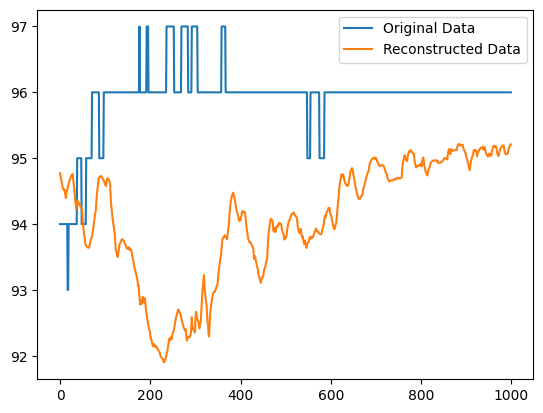

In [ ]:
plt.plot(input_df_train.SpO2[:1000], label='Original Data')
plt.plot(original_df_train.SpO2[:1000], label='Reconstructed Data')
plt.legend()
plt.show()

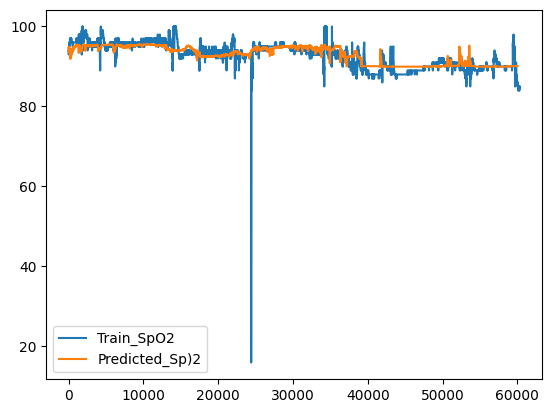

In [ ]:
plt.plot(input_df_train.SpO2, label='Train_SpO2')
plt.plot(original_df_train.SpO2, label='Predicted_Sp)2')
plt.legend()
plt.show()

In [ ]:
deviation = original_df_train - input_df_train

In [ ]:
deviation = deviation.dropna()

In [ ]:
rolling_mean = deviation.rolling( window = 100 ).mean()

# Calculate the deviation of each value from the rolling mean
deviation_df = deviation.sub(rolling_mean.shift(), fill_value=0)

In [ ]:
deviation_df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.771309,0.705719,0.467888,-4.724917,11.961937,11.237473,10.577156
1,0.733864,0.697189,0.444008,-4.716581,11.833801,11.069366,10.519356
2,0.701401,0.688507,0.422798,-2.709537,10.728249,10.925087,9.469902
3,0.658058,0.666290,0.387344,-2.701571,11.595062,10.719276,9.401386
4,0.620613,0.646790,0.356628,-2.694948,11.487755,10.548103,10.344536
...,...,...,...,...,...,...,...
60044,0.151350,-1.056880,-0.619046,0.587568,0.026365,-0.042379,0.000588
60045,0.140276,-1.037724,-0.608716,0.577819,0.021590,-0.047584,-0.006514
60046,0.129605,-1.017798,-0.597957,0.558575,0.028715,-0.052631,-0.009988
60047,0.119135,-0.997425,-0.587028,0.539129,0.037401,-0.053703,-0.012182


In [ ]:
deviation_df = deviation_df.dropna()

In [ ]:
deviation_df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.771309,0.705719,0.467888,-4.724917,11.961937,11.237473,10.577156
1,0.733864,0.697189,0.444008,-4.716581,11.833801,11.069366,10.519356
2,0.701401,0.688507,0.422798,-2.709537,10.728249,10.925087,9.469902
3,0.658058,0.666290,0.387344,-2.701571,11.595062,10.719276,9.401386
4,0.620613,0.646790,0.356628,-2.694948,11.487755,10.548103,10.344536
...,...,...,...,...,...,...,...
60044,0.151350,-1.056880,-0.619046,0.587568,0.026365,-0.042379,0.000588
60045,0.140276,-1.037724,-0.608716,0.577819,0.021590,-0.047584,-0.006514
60046,0.129605,-1.017798,-0.597957,0.558575,0.028715,-0.052631,-0.009988
60047,0.119135,-0.997425,-0.587028,0.539129,0.037401,-0.053703,-0.012182


In [ ]:
mean_deviation = deviation_df.sum(axis=0)/len(deviation_df)

In [ ]:
mean_deviation

SpO2     0.003502
HR       0.001072
PULSE    0.001257
RESP    -0.001375
ABP1     0.001666
ABP2    -0.004586
ABP3     0.003618
dtype: float64

In [ ]:
absolute_diff = deviation_df.apply(lambda row: abs(row - mean_deviation), axis=1)

In [ ]:
absolute_diff

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.767807,0.704647,0.466631,4.723543,11.960271,11.242059,10.573538
1,0.730361,0.696117,0.442751,4.715207,11.832135,11.073953,10.515738
2,0.697898,0.687435,0.421541,2.708162,10.726583,10.929673,9.466284
3,0.654556,0.665218,0.386087,2.700197,11.593396,10.723863,9.397768
4,0.617111,0.645718,0.355371,2.693573,11.486089,10.552690,10.340918
...,...,...,...,...,...,...,...
60044,0.147848,1.057953,0.620303,0.588943,0.024699,0.037792,0.003029
60045,0.136773,1.038796,0.609973,0.579194,0.019924,0.042998,0.010132
60046,0.126102,1.018870,0.599214,0.559950,0.027049,0.048044,0.013605
60047,0.115632,0.998497,0.588285,0.540503,0.035735,0.049116,0.015800


In [ ]:
standard_deviation_df = deviation_df.apply(lambda row: (row - mean_deviation)**2, axis=1)

In [ ]:
standard_deviation_df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.589527,0.496527,0.217744,22.311855,143.048080,126.383890,111.799710
1,0.533428,0.484579,0.196028,22.233173,139.999424,122.632432,110.580744
2,0.487062,0.472567,0.177697,7.334140,115.059573,119.457761,89.610536
3,0.428443,0.442515,0.149063,7.291062,134.406836,115.001234,88.318051
4,0.380826,0.416951,0.126289,7.255338,131.930235,111.359261,106.934585
...,...,...,...,...,...,...,...
60044,0.021859,1.119264,0.384776,0.346853,0.000610,0.001428,0.000009
60045,0.018707,1.079097,0.372067,0.335465,0.000397,0.001849,0.000103
60046,0.015902,1.038096,0.359057,0.313544,0.000732,0.002308,0.000185
60047,0.013371,0.996997,0.346080,0.292144,0.001277,0.002412,0.000250


In [ ]:
standard_deviation = np.sqrt(standard_deviation_df.sum(axis=0)/len(standard_deviation_df))

In [ ]:
standard_deviation

SpO2     1.154420
HR       1.504035
PULSE    2.749419
RESP     2.326304
ABP1     3.187300
ABP2     4.400567
ABP3     2.515678
dtype: float64

In [ ]:
Anomaly_score = absolute_diff/standard_deviation

In [ ]:
Anomaly_score

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.665102,0.468504,0.169720,2.030492,3.752478,2.554684,4.203057
1,0.632665,0.462833,0.161034,2.026909,3.712276,2.516483,4.180081
2,0.604545,0.457061,0.153320,1.164148,3.365414,2.483697,3.762916
3,0.567000,0.442289,0.140425,1.160724,3.637373,2.436928,3.735680
4,0.534564,0.429323,0.129253,1.157877,3.603705,2.398030,4.110589
...,...,...,...,...,...,...,...
60044,0.128071,0.703409,0.225613,0.253167,0.007749,0.008588,0.001204
60045,0.118478,0.690673,0.221855,0.248976,0.006251,0.009771,0.004028
60046,0.109234,0.677424,0.217942,0.240704,0.008487,0.010918,0.005408
60047,0.100165,0.663879,0.213967,0.232344,0.011212,0.011161,0.006280


In [ ]:
greater_than_array = Anomaly_score.gt(standard_deviation)

# Add a new column with 1 if the value is greater than the array value, 0 otherwise
Anomaly_score['anomaly'] = greater_than_array.any(axis=1).astype(int)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


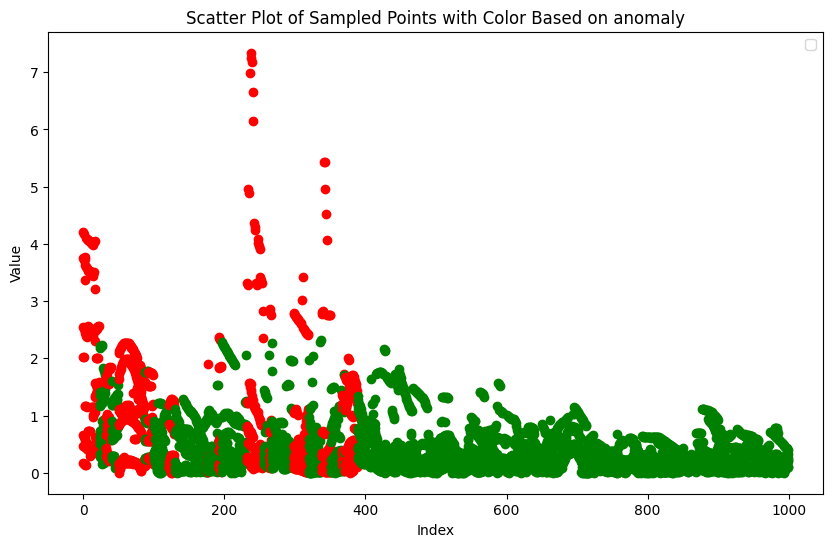

In [ ]:
# Get the indices where 'anomaly' is 1 (red points)
red_indices = Anomaly_score[Anomaly_score['anomaly'] == 1].index

# Sample a subset of points for plotting
sample_size = 1000  # Adjust this to change the number of points to plot
sampled_points = Anomaly_score[:sample_size]

# Plot the sampled points
plt.figure(figsize=(10, 6))

for index, row in sampled_points.iterrows():
    # Determine the color based on 'anomaly' value
    point_color = 'red' if row['anomaly'] == 1 else 'green'
    for col in Anomaly_score.columns[:-1]:  # Exclude the last column (anomaly)
        plt.scatter(index,row[col], color=point_color)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Sampled Points with Color Based on anomaly')
plt.legend()
plt.show()